# Task 4 - Site predictions (Pipeline)

This is just an extension for the Task_4 Notebook. Because we only used the whole Dataset, we want to do the process again for the different sites an look if we get further insights. In order to streamline the process, we tried to modulize the code and come up with funktions than cnbe called on differen datasets. 

In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Polynomial regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# Neural network
from keras import Sequential  # Sequential model: https://keras.io/guides/sequential_model/
from keras.layers import Dense, Dropout, BatchNormalization

# Import custom functions and utilities
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

# Time series analysis
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Environment settings
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Matplotlib settings
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29717 entries, 2018-04-25 04:00:00-07:00 to 2021-09-14 08:00:00-07:00
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   activeSessions_site2     29717 non-null  int64  
 1   utilizationRate_site2    29717 non-null  float64
 2   kWhDelivered_site2       29717 non-null  float64
 3   idleRate_site2           29717 non-null  float64
 4   blockedRate_site2        29717 non-null  float64
 5   activeSessions_site1     29717 non-null  int64  
 6   utilizationRate_site1    29717 non-null  float64
 7   kWhDelivered_site1       29717 non-null  float64
 8   idleRate_site1           29717 non-null  float64
 9   blockedRate_site1        29717 non-null  float64
 10  activeSessions_total     29717 non-null  int64  
 11  kWhDelivered_total       29717 non-null  float64
 12  utilizationRate_total    29717 non-null  float64
 13  idleRate_total           2971

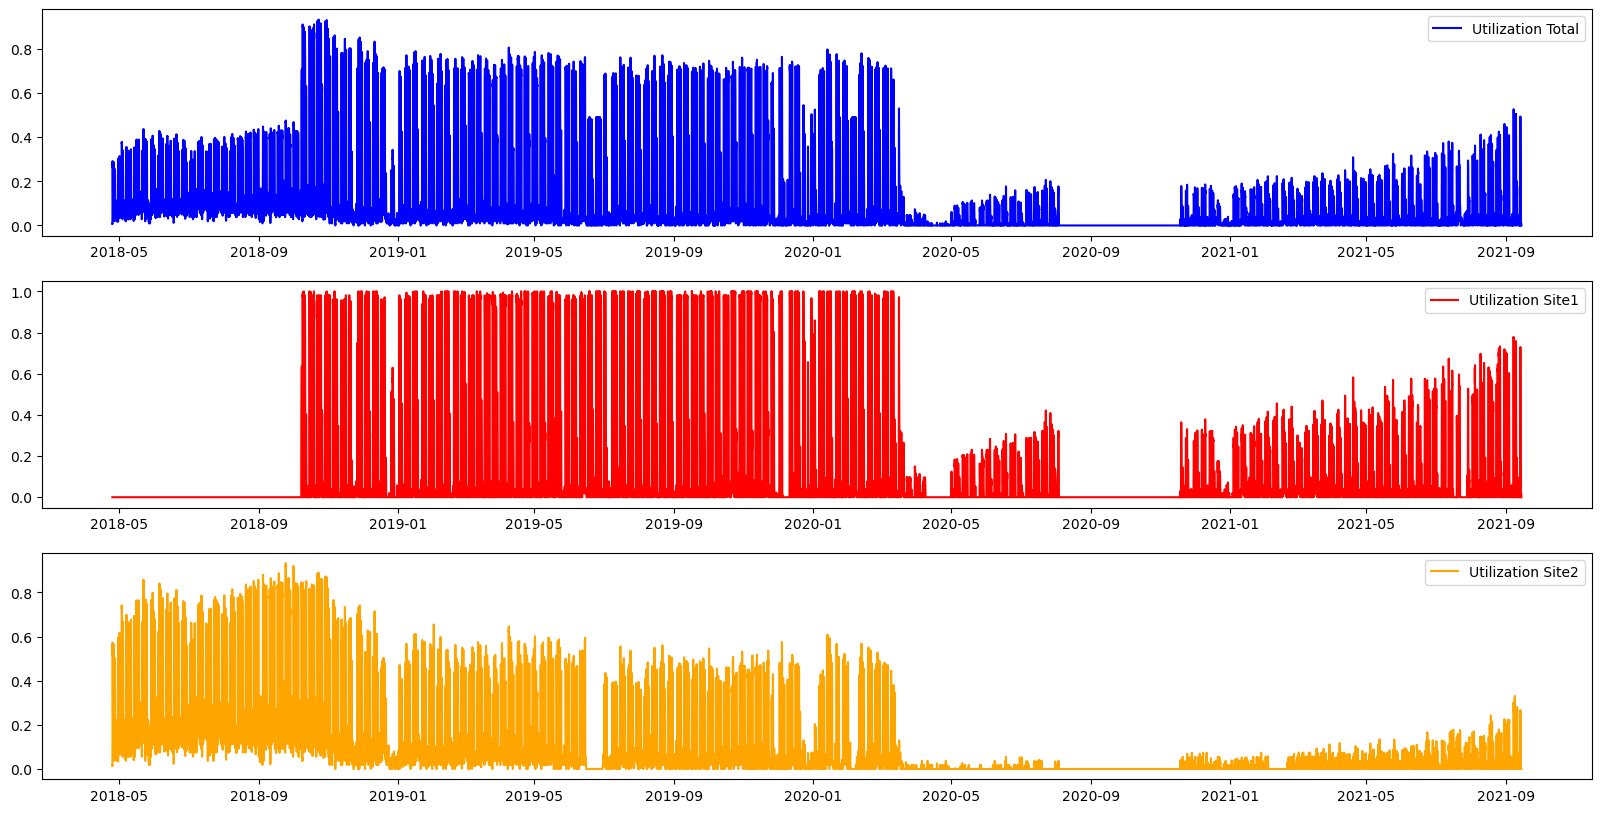

In [2]:
agg_charging_data = pd.read_pickle(os.path.join('Data', 'aggregated_data.pkl'))
agg_charging_data['year'] = agg_charging_data.index.year

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.plot(agg_charging_data.index, agg_charging_data['utilizationRate_total'], label='Utilization Total', color='blue')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(agg_charging_data.index, agg_charging_data['utilizationRate_site1'], label='Utilization Site1', color='red')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(agg_charging_data.index, agg_charging_data['utilizationRate_site2'], label='Utilization Site2', color='orange')
plt.legend()

agg_charging_data.info(20)

In [3]:
agg_charging_data = agg_charging_data[agg_charging_data['year'] == 2021]
agg_charging_data['week_of_year'] = agg_charging_data['week_of_year'].astype('int32')

# Datasets
datasets = [
    ("Gesamt", agg_charging_data[['utilizationRate_total', 'hour_of_day', 'day_of_week', 'year', 'month_of_year']], "utilizationRate_total"),
    ("Site1", agg_charging_data[['utilizationRate_site1', 'hour_of_day', 'day_of_week', 'year', 'month_of_year']], "utilizationRate_site1"),
    ("Site2", agg_charging_data[['utilizationRate_site2', 'hour_of_day', 'day_of_week', 'year', 'month_of_year']], "utilizationRate_site2")
]

In [4]:
# Preprocessing function
def preprocess_data(data, target_column):
    X = data[['hour_of_day', 'day_of_week', 'month_of_year', 'year']]
    y = data[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    return X_train, X_test, y_train, y_test

In [5]:
# Neural network training
def train_neural_network(X_train, y_train, X_test, y_test, epochs=20, batch_size=32):
    scaler = StandardScaler()
    X_train_nn = scaler.fit_transform(X_train)
    X_test_nn = scaler.transform(X_test)
    
    model = Sequential([
        Dense(32, activation='relu', input_dim=X_train_nn.shape[1]),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(X_train_nn, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=False)
    
    y_pred = model.predict(X_test_nn)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("Neural Network done!\n")

    return model, history, y_pred, mse, mae, r2

In [6]:
# Polynomial regression training
def train_polynomial_regression(X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
        ('polynomial_features', PolynomialFeatures()),
        ('scaler', StandardScaler()),
        ('ridge_regression', Ridge())
    ])
    param_grid = {
        'polynomial_features__degree': range(1, 6),
        'ridge_regression__alpha': np.logspace(-3, 2, 5)
    }
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    kf = KFold(n_splits=5, shuffle=False)
    grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring=scorer)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_  # Negate since we used negative MSE as the scoring

    print(f"Best Parameters: {best_params}")

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Regression model done!\n")
    
    return best_model, y_pred, mse, mae, r2

In [7]:
def time_series_analysis(data, target):
    data.index = pd.to_datetime(data.index)
    data.index.freq = 'H'
    data[target].replace(0, np.nan, inplace=True)
    data[target].fillna(method='bfill', inplace=True)
    data[target].fillna(method='ffill', inplace=True)

    # Decomposition
    ts_log = np.log(data[target])
    res = MSTL(ts_log, periods=(24, 24 * 7)).fit()

    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residuals = res.resid

    ts_log_decompose = residuals.copy()
    ts_log_decompose.interpolate(method='time', inplace=True)

    # Stationarity Test
    print("Testing stationarity...")
    dftest = adfuller(ts_log_decompose)
    print(f"Dickey-Fuller Test: p-value={dftest[1]}")

    # ARIMA Modeling
    lag_acf = acf(residuals.dropna(), nlags=20)
    lag_pacf = pacf(residuals.dropna(), nlags=20, method='ols')

    p = next((i for i, x in enumerate(lag_pacf) if abs(x) < 1.96 / np.sqrt(len(residuals.dropna())) and i > 0), None)
    d = 1
    q = next((i for i, x in enumerate(lag_acf) if abs(x) < 1.96 / np.sqrt(len(residuals.dropna())) and i > 0), None)

    print(f"Suggested ARIMA parameters: p={p}, d={d}, q={q}")

    split_ratio = 0.9
    train_size = int(len(ts_log_decompose) * split_ratio)
    residual_train, residual_test = train_test_split(ts_log_decompose, train_size=train_size, shuffle=False)

    model = ARIMA(residual_train, order=(p, d, q))  
    results_ARIMA = model.fit() 
    
    # Ensure frequency and alignment for all components
    full_index = pd.date_range(start=residuals.index.min(), end=residuals.index.max(), freq='H')
    residuals = residuals.reindex(full_index)
    trend = trend.reindex(full_index)
    seasonal = seasonal.reindex(full_index)

    # Fill missing values and ensure no NaNs
    residuals.interpolate(method='time', inplace=True)
    trend.interpolate(method='time', inplace=True)
    seasonal.interpolate(method='time', inplace=True)

    # Set consistent frequency
    residuals.index.freq = 'H'
    trend.index.freq = 'H'
    seasonal.index.freq = 'H'

    # Train-test split using slicing
    train_size = int(len(residuals) * split_ratio) 
    residual_train = residuals.iloc[:train_size]
    residual_test = residuals.iloc[train_size:]
    trend_train = trend.iloc[:train_size]
    trend_test = trend.iloc[train_size:]
    seasonal_train_1 = seasonal.iloc[:train_size, 0]
    seasonal_test_1 = seasonal.iloc[train_size:, 0]
    seasonal_train_2 = seasonal.iloc[:train_size, 1]
    seasonal_test_2 = seasonal.iloc[train_size:, 1]

    # Predict residuals using ARIMA
    residual_predictions = results_ARIMA.predict(start=len(residual_train), end=len(residuals) - 1)
    residual_predictions.index = residual_test.index

    # Align indices for all components
    trend_test.index = residual_test.index
    seasonal_test_1.index = residual_test.index
    seasonal_test_2.index = residual_test.index

    # Ensure predictions match in length
    assert len(residual_predictions) == len(trend_test), "Residual predictions length mismatch!"

    # Reconstruct predictions (in log scale)
    log_predictions = (
        residual_predictions
        + trend_test
        + seasonal_test_1
        + seasonal_test_2
    )

    # Apply inverse log transformation to return to original scale
    full_predictions = np.exp(log_predictions)

    # Trim full_predictions to match test data length
    full_predictions = full_predictions.iloc[:len(data.iloc[train_size:])]

    # Ensure the test set length matches full_predictions
    test = data.iloc[train_size:][target]
    assert len(test) == len(full_predictions), "Final lengths still do not match!"

    # Evaluate the model
    mse_arima = mean_squared_error(test, full_predictions)
    mae_arima = mean_absolute_error(test, full_predictions)
    r2_arima = r2_score(test, full_predictions)

    print("ARIMA model done!\n")

    return full_predictions, mse_arima, mae_arima, r2_arima


In [8]:
# Plotting function
def plot_results(y_test, y_pred_nn, y_pred_poly, y_pred_arima, title):
    indices = np.arange(len(y_test))
    y_pred_nn = np.maximum(0, y_pred_nn)
    y_pred_poly = np.maximum(0, y_pred_poly)
    
    plt.figure(figsize=(12, 6))
    plt.plot(indices, y_test, label='Actual Values', color='blue', alpha=0.7)
    plt.plot(indices, y_pred_nn, label='NN Predictions', color='red', alpha=0.7)
    plt.plot(indices, y_pred_poly, label='Poly Predictions', color='orange', alpha=0.7)
    plt.plot(indices, y_pred_arima, label='ARIMA Predictions', color='green', alpha=0.7)
    plt.title(title)
    plt.xlabel("Stunden")
    plt.ylabel("Utilization Rate")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Processing dataset: Gesamt
Training Neural Network...
Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0694 - mae: 0.1726 - val_loss: 0.0099 - val_mae: 0.0726
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0060 - mae: 0.0545 - val_loss: 0.0096 - val_mae: 0.0693
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0033 - mae: 0.0417 - val_loss: 0.0092 - val_mae: 0.0681
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - mae: 0.0350 - val_loss: 0.0090 - val_mae: 0.0671
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mae: 0.0301 - val_loss: 0.0088 - val_mae: 0.0664
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mae: 0.0279 - val_loss: 0.0086 - val_mae: 0.0653
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013 - mae: 0.0267 - val_loss: 0.0085 - val_mae: 0.0651
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 - mae: 0.0259 - val_loss: 0.0085 - val_mae: 0.0650
Ep

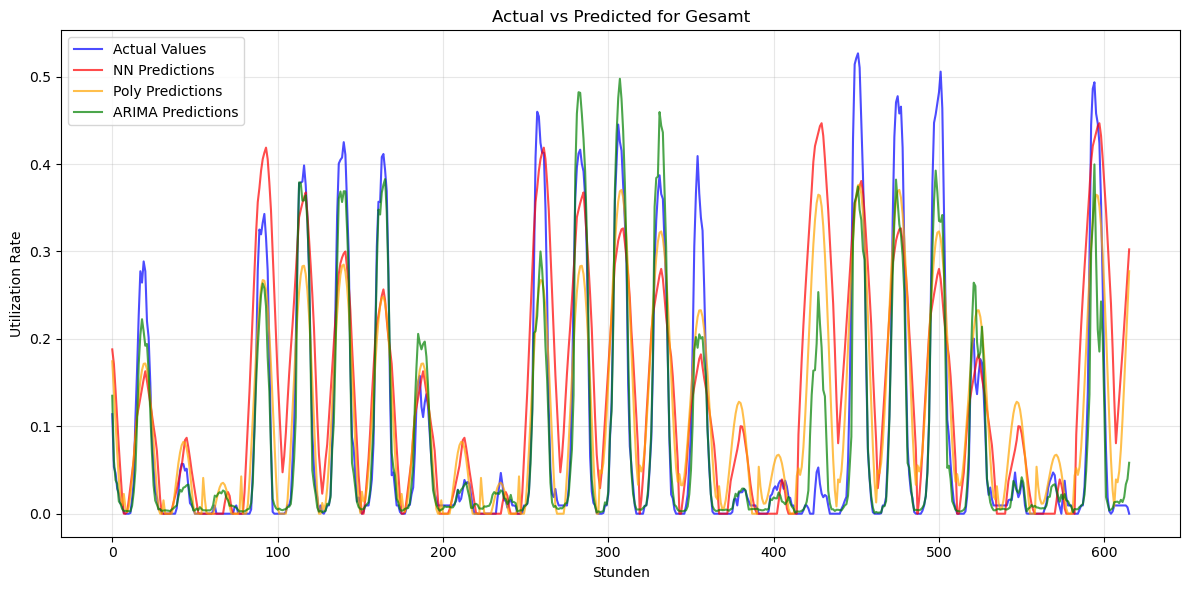

Performance results for Gesamt
NN - MSE: 0.012445470261786709, MAE: 0.08053068333471632, R²: 0.3870618391420152
Poly - MSE: 0.0065029005956450565, MAE: 0.0578837308447615, R²: 0.6797327985608195
ARIMA - MSE: 0.002471236695290584, MAE: 0.025567725274754143, R²: 0.8766921167489525
Finished processing for Gesamt

Processing dataset: Site1
Training Neural Network...
Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0141 - mae: 0.0901 - val_loss: 0.0354 - val_mae: 0.1342
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0168 - mae: 0.0953 - val_loss: 0.0262 - val_mae: 0.1239
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - mae: 0.0689 - val_loss: 0.0242 - val_mae: 0.1173
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0067 - mae: 0.0613 - val_loss: 0.0231 - val_mae: 0.1106
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0058 - mae: 0.0563 - val_loss: 0.0222 - val_mae: 0.1057
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5m

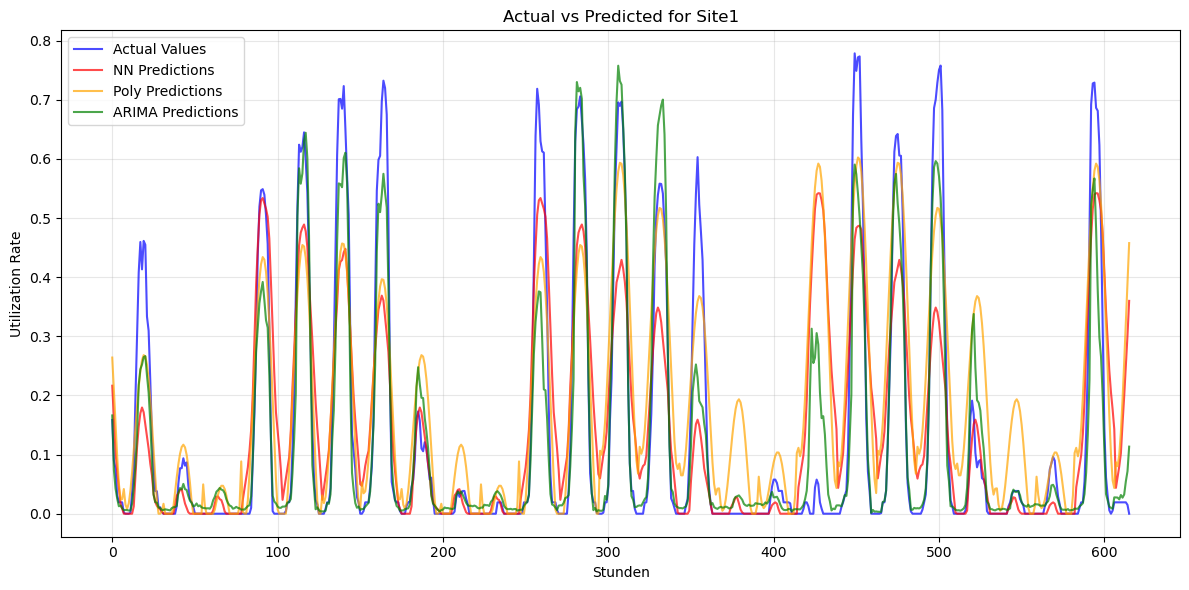

Performance results for Site1
NN - MSE: 0.01964660483482357, MAE: 0.0949152574581656, R²: 0.6063328636599934
Poly - MSE: 0.018607787439334517, MAE: 0.09771001232051336, R²: 0.627148076909333
ARIMA - MSE: 0.006793508416441774, MAE: 0.04326959966368855, R²: 0.8602358077240229
Finished processing for Site1

Processing dataset: Site2
Training Neural Network...
Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0076 - mae: 0.0614 - val_loss: 0.0029 - val_mae: 0.0396
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - mae: 0.0347 - val_loss: 0.0015 - val_mae: 0.0297
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 0.0014 - val_mae: 0.0290
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.6361e-04 - mae: 0.0210 - val_loss: 0.0014 - val_mae: 0.0286
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.1736e-04 - mae: 0.0178 - val_loss: 0.0013 - val_mae: 0.0280
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 

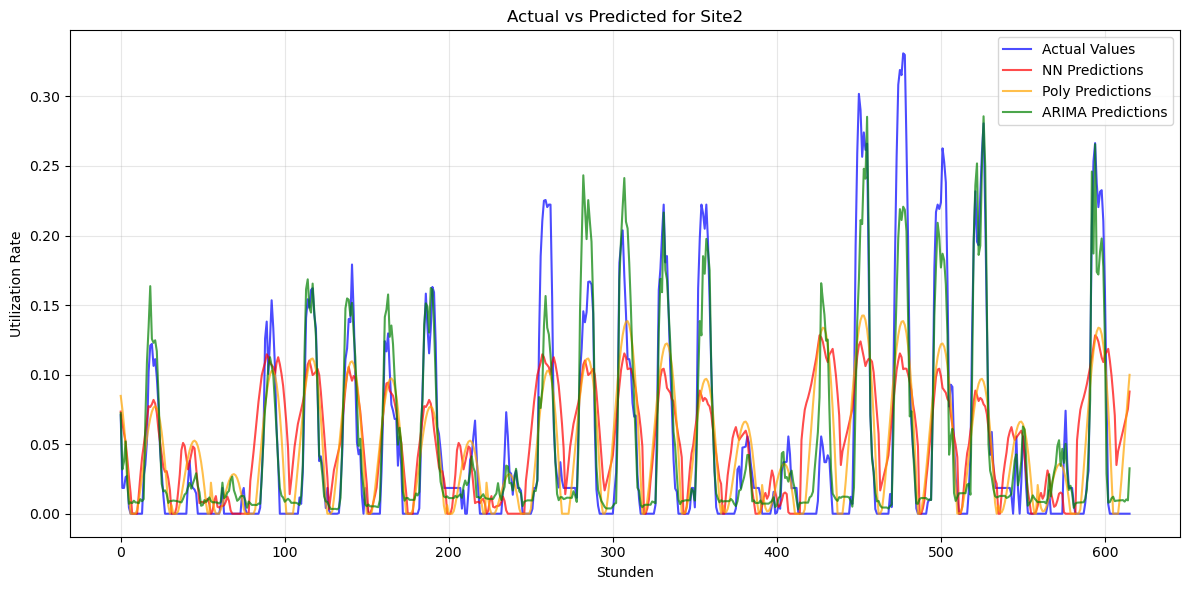

Performance results for Site2
NN - MSE: 0.003458670837240791, MAE: 0.043292284254629144, R²: 0.3864566746109914
Poly - MSE: 0.0024894189068255294, MAE: 0.034397719993588934, R²: 0.5583949944197389
ARIMA - MSE: 0.0007994207956467346, MAE: 0.016318173352166968, R²: 0.8468787375615809
Finished processing for Site2



In [9]:
# Main Processing Loop
for name, data, target in datasets:
    print(f"Processing dataset: {name}")
    
    # Preprocessing
    X_train, X_test, y_train, y_test = preprocess_data(data, target)
    
    # Neural Network Training
    print("Training Neural Network...")
    nn_model, nn_history, nn_pred, nn_mse, nn_mae, nn_r2 = train_neural_network(X_train, y_train, X_test, y_test)
    
    # Polynomial Regression Training
    print("Training Polynomial Regression...")
    poly_model, poly_pred, poly_mse, poly_mae, poly_r2 = train_polynomial_regression(X_train, y_train, X_test, y_test)
    
    # Time Series Analysis
    print(f"Performing time series analysis...")
    ts_predictions, mse_arima, mae_arima, r2_arima = time_series_analysis(data, target)

    # Plot Results
    plot_results(y_test, nn_pred, poly_pred, ts_predictions, f"Actual vs Predicted for {name}")
    print(f"Performance results for {name}")
    print(f"NN - MSE: {nn_mse}, MAE: {nn_mae}, R²: {nn_r2}")
    print(f"Poly - MSE: {poly_mse}, MAE: {poly_mae}, R²: {poly_r2}")
    print(f"ARIMA - MSE: {mse_arima}, MAE: {mae_arima}, R²: {r2_arima}")
    

    print(f"Finished processing for {name}\n")

The performances varie per site, with ARIMA always being the best performing.